# Question Answering

Irrespective of profession, everyone has to wade through ocean of documents at some point to find the information for their questions.  To make matters worse, we're constantly reminded by search engines there are better ways to search! For instance the earch query "When did Marie Curie win her first Nobel Prize?" And google get the correct answer of "1903".

So how was this search done? Google first retrieved 319,000 documents that were relevant to query, then performed a post processing step to extract the answer snippet with the coressponding passage and web page. But for a more trickier question like "Which guitar tuning is best?" We'll get web pages instead of an answer snippet.

The general approach behind this technology is called *question answering*(QA), but the most common is *extractive QA* which involves questions where answers can be identified as a span in a text document, where the document might be a web page, article, legal document etc.

This two stage process of retrieving relevant documents and then extracting answers from this is the basis of many modern QA systems like semantic search, intellegint assistants and automated information extractors. 

> **Note:** We're covering only extractive QA. There are others,
 * community QA Ex: In stack overflow, all the relevant question answer pairs will be retrived for the new Question from user and then using semantic similarity search to find the closest maching answer to this question.
 * long-form QA, which aims to generate complex paragraph-length answers to open ended questions like "Why sky is blue?"
 * QA can be done over tables as well, and transformer models like TAPAS can even peroform aggregations to produce the final answer!

## Use Case

In this notebook, we'll use QA system to solve a common problem facing ecommerce websites: helping consumers evaluate a product by answering specific queries. We'll see that the customer reviews can be used as a rich and challenging source of information for QA. Along the way we'll learn transformers capbality of *reading comprehehsion* and how the model can extract meaning from text.

## Building a Review-Based QA System

Let's say we want to buy a smartphone, and we've question on nightmode camera capbalities. This information is not readily available in product description. We can find the answer for this in reviews by other customers. But we might've to comb throuch thousands of reviews to find the relevant answer. It'll be great if we can have a search like google right? Let's do this using transformers!

### The Dataset

To build our QA system, we'll use [SubQA](https://arxiv.org/abs/2004.14283) dataset, which consists of 10,000+ reviews where each review is associated with a question and answer from one or more sentences from the review. The reviews are about products and services in six domains: TripAdvisor, Restaurants, Movies, Books, Electronics and Grocery.

*Data example*

![alt](../notes/images/7-question-answering/subqa-data-sample.png)

The intersting aspect of this dataset is question(from users), answers(extraced from reviews) are *subjective*. The question on camera quality from user, the quality is subjective to each user and answer might not be from the same point of view question is raised... This is why it's easier to answer fatcual questions like "What's the capital of a country"
Second, important parts of the question do not appear in review at all, so we can't use shortcuts like keyword search or paraphrasing the input question.

Because of these points, SubQA is a greate dataset to benchamrk review-based QA models, sicne user-generated content in the example resembles what we might encounter in the wild.

> **Note:** QA systems are categorized accordig to the domains it has access to while answering the questions. 
  * *Narrow QA* answers question about a single product less documents to search
  * *Open-domain QA* deals with questions about almost anything(eg. amazon's whole product catalog.) more documents to search

### The Dataset

To build our QA system, we'll use [SubQA](https://arxiv.org/abs/2004.14283) dataset, which consists of 10,000+ reviews where each review is associated with a question and answer from one or more sentences from the review. The reviews are about products and services in six domains: TripAdvisor, Restaurants, Movies, Books, Electronics and Grocery.

*Data example*

![alt](../notes/images/7-question-answering/subqa-data-sample.png)

The intersting aspect of this dataset is question(from users), answers(extraced from reviews) are *subjective*. The question on camera quality from user, the quality is subjective to each user and answer might not be from the same point of view question is raised... This is why it's easier to answer fatcual questions like "What's the capital of a country"
Second, important parts of the question do not appear in review at all, so we can't use shortcuts like keyword search or paraphrasing the input question.

Because of these points, SubQA is a greate dataset to benchamrk review-based QA models, sicne user-generated content in the example resembles what we might encounter in the wild.

> **Note:** QA systems are categorized accordig to the domains it has access to while answering the questions. 
  * *Narrow QA* answers question about a single product less documents to search
  * *Open-domain QA* deals with questions about almost anything(eg. amazon's whole product catalog.) more documents to search

### The Dataset

To build our QA system, we'll use [SubQA](https://arxiv.org/abs/2004.14283) dataset, which consists of 10,000+ reviews where each review is associated with a question and answer from one or more sentences from the review. The reviews are about products and services in six domains: TripAdvisor, Restaurants, Movies, Books, Electronics and Grocery.

*Data example*

![alt](../notes/images/7-question-answering/subqa-data-sample.png)

The intersting aspect of this dataset is question(from users), answers(extraced from reviews) are *subjective*. The question on camera quality from user, the quality is subjective to each user and answer might not be from the same point of view question is raised... This is why it's easier to answer fatcual questions like "What's the capital of a country"
Second, important parts of the question do not appear in review at all, so we can't use shortcuts like keyword search or paraphrasing the input question.

Because of these points, SubQA is a greate dataset to benchamrk review-based QA models, sicne user-generated content in the example resembles what we might encounter in the wild.

> **Note:** QA systems are categorized accordig to the domains it has access to while answering the questions. 
  * *Narrow QA* answers question about a single product less documents to search
  * *Open-domain QA* deals with questions about almost anything(eg. amazon's whole product catalog.) more documents to search

To get started , let's download the dataset from hub. we can use the `get_dataset_config_names()` function to find out which subsets are available:

In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In this notebook, we'll be focusing on developing a QA system for Electronic domain. To do that let's download the `electronics` subset.

In [2]:
from datasets import load_dataset
subjqa = load_dataset(
    path="subjqa",
    name="electronics"
)

Reusing dataset subjqa (/Users/jayaprakashsivagami/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd)


In [3]:
subjqa

DatasetDict({
    train: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 1295
    })
    test: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 358
    })
    validation: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 255
    })
})

In [4]:
# Features in the dataset
for i in subjqa["train"].features:
    print(i)

domain
nn_mod
nn_asp
query_mod
query_asp
q_reviews_id
question_subj_level
ques_subj_score
is_ques_subjective
review_id
id
title
context
question
answers


Like other question answering datasets on the Hub, SubjQA stores the answers to each questions as a nested dictionary. Let's inspect the answers column.

In [5]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [6]:
# Answers has other nested keys inside
for k, v in subjqa["train"]["answers"][1].items():
    print(k)
    print(v)
    print("")

text
['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up']

answer_start
[1302, 1302]

answer_subj_level
[1, 1]

ans_subj_score
[0.5083333253860474, 0.5083333253860474]

is_ans_subjective
[True, True]



The answers are stored in `text` field, while the starting character indices are provided in `answer_start`. To explore the dataset more easily, let's flatten the nested dict and convert this to a `DataFrame`.

We'll use dataset's [flatten()](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.flatten) to do this.

In [7]:
import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [8]:
dfs["train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   domain                     1295 non-null   object 
 1   nn_mod                     1295 non-null   object 
 2   nn_asp                     1295 non-null   object 
 3   query_mod                  1295 non-null   object 
 4   query_asp                  1295 non-null   object 
 5   q_reviews_id               1295 non-null   object 
 6   question_subj_level        1295 non-null   int64  
 7   ques_subj_score            1295 non-null   float32
 8   is_ques_subjective         1295 non-null   bool   
 9   review_id                  1295 non-null   object 
 10  id                         1295 non-null   object 
 11  title                      1295 non-null   object 
 12  context                    1295 non-null   object 
 13  question                   1295 non-null   objec

In [9]:
dfs["train"].head(2).T

,0,1
domain,electronics,electronics
nn_mod,great,harsh
nn_asp,bass response,high
query_mod,excellent,not strong
query_asp,bass,bass
q_reviews_id,0514ee34b672623dff659334a25b599b,7c46670208f7bf5497480fbdbb44561a
question_subj_level,5,1
ques_subj_score,0.5,0.5
is_ques_subjective,False,False
review_id,882b1e2745a4779c8f17b3d4406b91c7,ce76793f036494eabe07b33a9a67288a


There are quite a few columns, we'll use the below columns for this use case:

1. `title` -> Amazon Standard Identification Number (ASIN) associated with each product
2. `question` -> Question itself
3. `answers.answer_text` -> The span of text in the review labelled by annotator
4. `answers.answer_start` -> The start charachter index of the answer span
5. `context` -> The customer review

Let''s look at these columns alone.

In [10]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df 

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


Observations:

* The queries are not gramatically correct which is quite common in the FAQ sections of ecommerce websites.
* An empty `amswers.text` entry denotes "unanswerable" questions whose answer cannot be found in the review.
* We can use the start index and length of the answer span to slice out the span to get the answer from the text.

In [11]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
start_idx

215

In [12]:
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
end_idx

239

In [13]:
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

In [14]:
sample_df["answers.text"].iloc[0]

array(['this keyboard is compact'], dtype=object)

By predicting the start index and length of the answer, we can create a qa model.

Next, let's get a feel for what types of questions are available in the training set by counting the questions that starts with a few common starting words for questions:

In [15]:
counts = {}
# Here we're assuming all users will start the question with capital letter...
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    # Get the questions start with q using value_counts()
    # value_counts() returns count for True(1st index) and False(0th index)
    # Get true from ther value_counts() and save it to dict
    false_true = dfs["train"]["question"].str.startswith(q).value_counts()
    if len(false_true) == 2:
        counts[q] = false_true[1]
    else:
        counts[q] = 0
counts

/var/folders/s2/zc28s499001f26bz7nbfmfhr0000gn/T/ipykernel_1703/933638907.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  counts[q] = false_true[1]


{'What': 236,
 'How': 515,
 'Is': 100,
 'Does': 45,
 'Do': 83,
 'Was': 12,
 'Where': 28,
 'Why': 21}

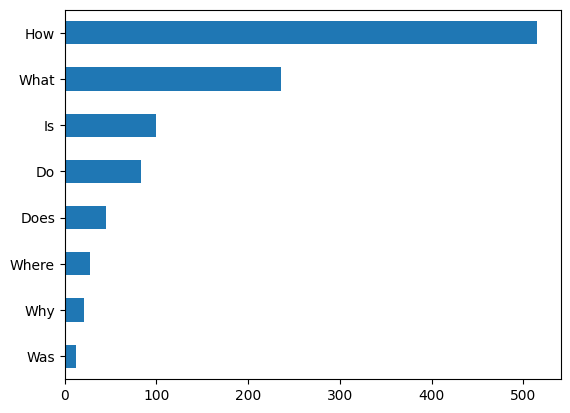

In [16]:
# Let's plot this
import matplotlib.pyplot as plt
pd.Series(counts).sort_values().plot.barh()
plt.show()

Most common questions begins with "How", "What", and "Is", let's have a look at some examples:

In [17]:
for question_type in question_types:
    print(question_type)
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)].sample(n=3, random_state=42)["question"]
    ):
        print(question)
    print("")

What
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?

How
How is the camera?
How do you like the control?
How fast is the charger?

Is
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?

Does
Does the camera include control?
Does the product have good quality?
Does this provide enough storage?

Do
Do you have a price for a shoes?
Does this headphone excellent?
Do they come with the manufacturer's seal?

Was
Was the drive absolutely perfect?
Was prompt the delivery?
Was the mountain high?

Where
Where is the cheapest price?
Where can I send to setup my device?
Where do I have a drawer full of headphones?

Why
Why do I have an incredible sound?
Why is customer service excellent?
Why this feature affect the move?



### Question Answering Dataset history

 The (question, review, [answer setences]) format of SubjQA(used in [7-question-answering.ipynb notebook usecase for qa](../notebooks/7-question-answering.ipynb)) is commonly used in extractive QA datasets and was pioneered in Stanford Question Answering Dataset(SQuAD). 

 * SQuAD is a famous dataset to test the abilit of machines(models) to read a passage of text and answer questions about it
 * This dataset was created from several hundred articles from wikipedia, where each of the article was partioned into paragraphs. Then crowdworkers were asked to generate questions and answers for each paragraph.
 * In the first crowdworkers version of SQuAD, answers for questions were guaranteed to be in paragraphs.
 * Soon sequence to sequence models outperformed humans and predicted spans of answers for question in the context(paragraphs, reviews etc.)
 * SQuAD 2.0 was created by augmenting SQuAD 1.1 with a set of adversial questions that were relevant to the passage but can't be answered from the passage contents alone. This became a better benchmark for evaluation qa capabalities of machines.
 * SOTA models as of 2022 with most models since 2019 surpasses human performance.
    *qa sota models timeline*

    ![alt](../notes/images/7-question-answering/qa-sota-models.png)
* However this superhuman performance does not appear to reflect genuine reading comprehension, since answers to these "unanswerable" questions can be found by looking at antonymns in passages. 
* To address these problems Google released the Natural Questions (NQ) dataset which involves fact-seeking questions obtainef from Google Search users.
* The answers in NQ are much longer than in SQuAD and present a more challenging benchmark.

```
NQ >> SQuAD2.0 >> SQuAD
```

Now let's dive into how transformers can extract answers from text.

### Extracting Answers from Text

The first thing we'll need for our QA systems is to find a way to identify potential answers as span of text in a customer review. To do this, we'll need to understand how to:

1. Frame the supervised learning problem
2. Tokenize and encode text for QA tasks
3. Deal with long passages that exceed a model's maximum context size

#### Frame the problem - span classification

The most common way to extract answers is ny framing the problem as *Span classification task* where start and end tokens acts as lables to be predicted by the model.

*qa span classification*

![alt](../notes/images/7-question-answering/qa-span-classification.png)

In general we'll start with a pretrained model and evaluate it on the dataset to use it as a baseline and then fine-tune the model for the use case. But for extractive QA , we can actually start with fine-tuned model because the structure of labels remain the same. Since our training set is realtivley small with only 1,295 samples, A good strategy is to use a model fine-tuned on large-scale QA dataset like SQuAD.

*SQuAD models on hub as of 2nd Sep 2023*

![alt](../notes/images/7-question-answering/squad-models-on-hub.png)

Woah... 4000+ models are available, which model to use depends on mono or multi-lingual and production environment constraints.

*Baseline transformer models fine-tuned on SQuAD 2.0*
| Transformer | Description | Num of Params | F1-Score |
|----------|----------|----------|----------|
| MiniLM   | Distilled version of BERT-base that preserves 99% performance while being twice as fast   | 66M | 79.5 |
| RoBERTa-base | RoBERTa models have better performance than their BERT counterparts and can be fine-tuned on most QA datastes using a single GPU | 125M| 83.0 |
| ALBERT-XXL | SOTA on datasetm but computationally intensive and difficult to deploy | 253M | 88.1 |
| XLM-RoBERTa-large | Multilingual model for 100 languages with strong zero-shot performance | 570M | 83.8 |

In this notebook, we'll use MiniLM model since it is fast to train and will allows to iterate quickly to explore techniques. First we need the tokenizer to encode our texts. Let's take a look at how this works for QA tasks.

### Tokenizing text for QA

In [18]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path=model_ckpt
)
tokenizer

BertTokenizerFast(name_or_path='deepset/minilm-uncased-squad2', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

> **Note:** In QA model inputs are passed as question, context pairs.

In [19]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [20]:
from tabulate import tabulate
inputs_norm = tokenizer(question, context)
inputs_norm["tokens"] = inputs_norm.tokens()
pd.DataFrame.from_dict(inputs_norm, orient="index")

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
tokens,[CLS],how,much,music,can,this,hold,?,[SEP],an,...,so,about,6000,hours,depending,on,file,size,.,[SEP]


> **Note:** `token_type_ids` --> this is used to differentiate two segments of inputs where it's passed as pair. Ex in QA inputs question tokens will have token_type_ids as 0 and context will have 1.`

In [21]:
# Let's understand how the tokenizer formats the inputs for QA tasks. Let's decode the input_ids tensor
print(tokenizer.decode(inputs["input_ids"][0]))

2023-09-19 06:34:12.616502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [22]:
print(tokenizer.decode(inputs["token_type_ids"][0]))

[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0]


In [23]:
print(tokenizer.decode(inputs["attention_mask"][0]))

[unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0] [unused0]


The inputs take the below format
[CLS] question tokens [SEP] context tokens [SEP].
Where the first [SEP] token is determined by the `token_type_ids`

Now that the text is tokenizer, let's instantiate the model with QA head and run the inputs through the forward pass.

In [24]:

import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [25]:
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


Here we can see that we get a `QuestionAnsweringModelOutput` object as the output of the QA head. The QA head corresponds to a linar layer that takes hidden states from encoder and computes the logits for start and end spans. This means that we treat QA as a form of token classification similar to ner in notebook 4.

We've start_logits and end_logits in the output, let's get these to conver the span into answers.

In [26]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [27]:
# Comparing this with input ids which is the review/context
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits size: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits size: torch.Size([1, 28])


In [28]:
question, context

('How much music can this hold?',
 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.')

How can we use the logits to determine the answer, let's write some code to visualize start and end logits with their respective tokens.

We'll implement a bar graph with token ids in x axis and logits in y axis.

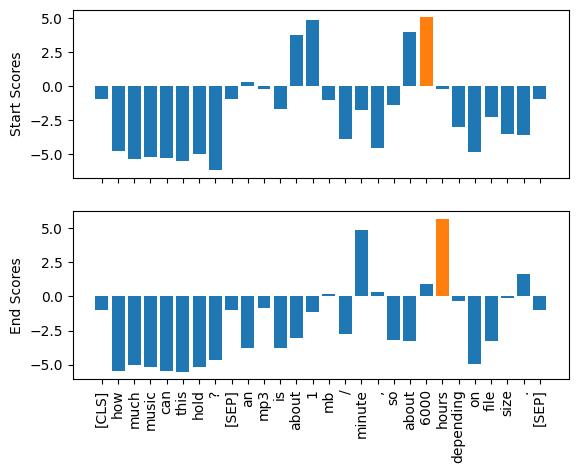

In [29]:
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
token_ids = range(len(tokens))

fig, (ax1, ax2) = plt.subplots(
    nrows=2, # s and e_logits
    sharex=True, # Token ids
    )

colors = ["C0" if s != max(s_scores) else "C1" for s in s_scores]
ax1.bar(
    x=token_ids,
    height=s_scores,
    color=colors,
)
ax1.set_ylabel("Start Scores")

colors = ["C0" if s != max(e_scores) else "C1" for s in e_scores]
ax2.bar(
    x=token_ids,
    height=e_scores,
    color=colors,
)
ax2.set_ylabel("End Scores")
plt.xticks(token_ids, tokens, rotation="vertical")
plt.show();


In [30]:
question

'How much music can this hold?'

Looking at the visualization, the highest logits for start and end span tokens are 6000, 1 and hours and minute respectivley.
With this respect to the question, the answer should be a number following by the unit of the number. The results look good.

Let's perform an argmax over the tokens to get the start and end token ids.

Looking at the visualization the logits for questions until first [SEP] which is the question are really low towards -5.
The model is able to differentiate between question and context and tries to find the span token in context.

In [31]:
import torch
start_span, end_span = torch.argmax(start_logits), torch.argmax(end_logits) + 1
print(tokens[start_span:end_span])
print(tokenizer.decode(inputs["input_ids"][0][start_span:end_span]))

['6000', 'hours']
6000 hours


In [32]:
start_span, end_span

(tensor(20), tensor(22))

We have transformers pipeline which can do all this input to ids, forward pass, logits, decode logits, get answer in a single line of code.

In [33]:
from transformers import pipeline
pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/Users/jayaprakashsivagami/miniconda3/envs/nlp-qa/lib/python3.9/site-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.26516270637512207,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.22082945704460144,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253455489873886,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In addition to answer we get,
* `score` --> softmax over the logits, to compare multiple answers for a single context
* topk gives three top answers, multiple answers for a single question
* When the question is unanswerable, model will assign a high start and end score to the [CLS] with pipeline output an empty string

In [34]:
pipe(question="Why is there no data?", context=context, topk=3, handle_impossible_answer=True)

[{'score': 0.9068412780761719, 'start': 0, 'end': 0, 'answer': ''},
 {'score': 0.00026264842017553747,
  'start': 16,
  'end': 71,
  'answer': '1 MB/minute, so about 6000 hours depending on file size'},
 {'score': 0.0002036133810179308,
  'start': 10,
  'end': 71,
  'answer': 'about 1 MB/minute, so about 6000 hours depending on file size'}]

In [35]:
context

'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.'

> **Note:** In our simple example we took the argmax to get start and end tokens. But this heuristic approach can product out-of-scope results by selecting the tokens belonging to question instead. In practice start and end tokens computed by pipeline has many considerations like answer being in scope, start indices to precede the end indices and so on.

### Dealing with long passages

One subtely faced by reading comprehension models is that the context often contains more tokens than the maximum sequence length of the model.
Let's check this out for SubjQA dataset.

In [36]:
def compute_input_length(row):
    """_summary_

    Accepts a single dataframe row and returnsd length of tokens for qa inputs

    Args:
        row (_type_): SubjQA dataset single row
    """
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

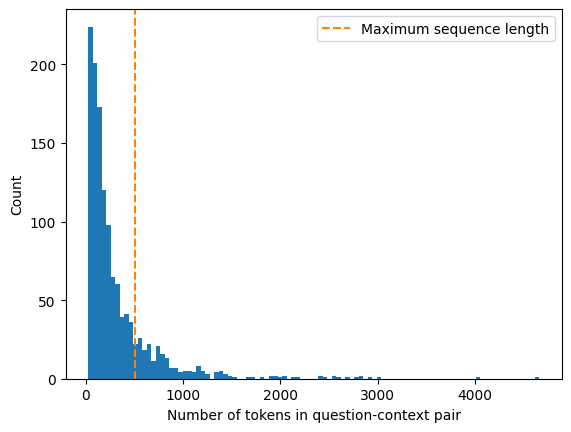

In [37]:
fig, ax = plt.subplots(nrows=1)
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1", 
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show();

Decent portion of SubjQA's inputs are also beyond MiniLM's maximum context length.

For other tasks like classification we'll truncate the text assuming [CLS] token would've assimilated information from all other tokens to generate accurate predictions. But with QA the answers might lie at the end of the context and we might lose the answer if we truncate it. The standard way to deal with this is to apply a *sliding window* across the inputs, where each window contains a passage of token that fits the model's context.

In transformers, we can set `return_overflowing_tokens=True` in the tokenizer to enable the sliding window. The size of the sliding window is controlled by `max_seq_length` argument. and the size of the stride is controlled by `doc_stride`. Let's grab the first example from out training set and define a small window to see how sliding window works...

In [38]:
example = dfs["train"].iloc[0][["question", "context"]]
example

question                                     How is the bass?
context     I have had Koss headphones in the past, Pro 4A...
Name: 0, dtype: object

In [39]:
tokenized_example = tokenizer(
    example["question"], example['context'],
    return_overflowing_tokens=True,
    max_length=100,
    stride=25
    )

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [40]:
print(f"Full input")
print(f"Question: {example['question']}")
print(f"Context: {example['context']}")
print("")
for idx, window in enumerate(tokenized_example['input_ids']):
    print(f"Window {idx} has {len(window)} tokens")
    print(f"{tokenizer.decode(window)}\n")

Full input
Question: How is the bass?
Context: I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.

Window 0 has 100 tokens
[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and 

* The question comes in all the windows
* The first window context spans the length of max_length
* From second window, move back by stride_length from previous window's end token, this is the starting point of curent window and spans the length of max_length. This process is repeated until the sequence ends.
* All the windows overlap with previous window by stride length.

Now With some intution about how QA models can extract answers from text, let's look at other components we need to build an end-to-end QA pipeline.

### Using Haystack to Build a QA pipeline

In our example above, we've fed the pipeline or model both question and context. But in reality we'll get only the query from user and we've get the context from our corpus. There are few ways to do it:

#### Simple Approach

Simple and easiest approach is to concatenate all the reviews available as a single context and feed it with question to the model. The bottleneck will be the computation to process, because the context is big due to concatenation. Let's assume it takes 100 milliseconds to process a review with 30 reviews and the model will take 3 seconds latency after users input which won't work in an ecommerece application.

To overcome this, moder QA system uses retriever-reader approach:

#### Retriever-Reader architecture

##### Retriever

Retriever is responsible for retrieving relevant documents for the user query. They are categorized as sparse and dense

1. *Sparse Retrievers*: This uses word frequencies to represent a document. The query is also a sparse vector. The relevancy of document for the query is determined by computing an inner product of both vectors.
2. *Dense Retrievers*: This stores documents as contextualized embeddings. The query is converted into a dense vector using encoder like transformers. Then both query and documents are compared, semantic meaning is available with embeddings. This allows for a more accurate search of documents by understanding the content of the query.

##### Reader

Responsible for extracting an answer from the documents provided by the retriver. These can be reading comprehension models(extract answers from text) or free-form answers from generative tranformers.

There can be post-processing after retriver or reader and both as well. Like ranking the documents from retriever to remove noisy passages or postprocessing answer by combining answer from various passages in a long document.

*Modern qa architecure*:

![alt](../notes/images/7-question-answering/qa-modern-architecture.png)

To build our QA system, we'll use the [Haystack library](https://haystack.deepset.ai/) developed by [deepset](https://deepset.ai/). Haystack is based on retriever-reader architecure and tighty coupled with transformers to abstract away the complexity in building these systems.

In addition to retriever and reader an QA system requires two more components:

##### Document store

A document-oriented database that stores documents and metadata which are provided to the retriever at query time

##### Pipeline

Combines all the components of QA system to enable custom query flows, merging documents from multiple retrievers and more.

Next we'll explore how to build a prototype popeline and then focus on improving it's performance.

### Initializing a document store

In Haystack, there are various [document stores](https://docs.haystack.deepset.ai/docs/document_store) to choose from and each one can be paired with a dedicated set of retrievers.

Below table shows the compatability os sparse(TF-IDF, BM25) and (Embedding, DPR) retrievers is shown for ElasticSearch and FAISS.

![alt](../notes/images/7-question-answering/qa-haystack-document-stores.png)

To explore both dense and sparse retrievers, we'll use `ElasticSearchDocumentStore`, which is compatible with both retriever types. Elastic search can handle variety of datatypes. It can also store huge volumes of data and retrieve them using Full-text search feature, this makes ElasticSearch well suited to develop QA systems.

To initalize a document store, let's first install ElastiSearch.

I've setup elastic using docker-compose. [docker-compose.yaml](../others/docker-compose.yaml) can be used to spin up an elastic docker service. [.env file is available in elastic search geting started tutorial](https://www.elastic.co/blog/getting-started-with-the-elastic-stack-and-docker-compose)

In [41]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [42]:
!curl --insecure --user "elastic:password" "https://localhost:9200/?pretty"

{
  "name" : "es01",
  "cluster_name" : "qa-cluster",
  "cluster_uuid" : "a8q1_L82SACd5T6_zt-06g",
  "version" : {
    "number" : "8.7.1",
    "build_flavor" : "default",
    "build_type" : "docker",
    "build_hash" : "f229ed3f893a515d590d0f39b05f68913e2d9b53",
    "build_date" : "2023-04-27T04:33:42.127815583Z",
    "build_snapshot" : false,
    "lucene_version" : "9.5.0",
    "minimum_wire_compatibility_version" : "7.17.0",
    "minimum_index_compatibility_version" : "7.0.0"
  },
  "tagline" : "You Know, for Search"
}


Alright, now we've our elastic server up and running, let's instantiate the document store.

In [3]:

from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever 
document_store = ElasticsearchDocumentStore(
    host="localhost",
    port="9200",
    scheme="https",
    username="elastic",
    password="password",
    ca_certs="../others/ca.crt",
    return_embedding=True,
    )

This ElasticsearchDocumentStore has been built for Elasticsearch 7, but the detected version of the Elasticsearch server is 8.7.1. Unexpected behaviors or errors may occur due to version incompatibility.


By default, `ElasticSearchDocumentStore` creates two indices on ElasticSearch: one called `document` for storing documents and another called `label` for storing the annotated answer spans. For now, we'll just load the SubjQA reviews to document index. Haystack's document stores expect a list of dictionaries with `text` and `meta` keys as follows:

```JSON
{
    "text": "context",
    "meta": {
        "field_01": "additional metadata",
        "field_02": "additional metadata"
    }
}
```

The fields in `meta` can be used for applying filters during retrieval. For our purposes we'll include the `item_id` and `q_review_id` columns of SubjQA so we can filter by product and question ID, along with corresponding training split. We can then convert it to dataframe and loop through them to add it to index using `write_documents()`

In [44]:
# It's a good idea to flush ES with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents(index="document")
    document_store.delete_documents(index="label")

In [45]:
dfs["train"]

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective,n_tokens
0,electronics,great,bass response,excellent,bass,0514ee34b672623dff659334a25b599b,5,0.50,False,882b1e2745a4779c8f17b3d4406b91c7,2543d296da9766d8d17d040ecc781699,B00001P4ZH,"I have had Koss headphones in the past, Pro 4A...",How is the bass?,[],[],[],[],[],155
1,electronics,harsh,high,not strong,bass,7c46670208f7bf5497480fbdbb44561a,1,0.50,False,ce76793f036494eabe07b33a9a67288a,d476830bf9282e2b9033e2bb44bbb995,B00001P4ZH,To anyone who hasn't tried all the various typ...,Is this music song have a goo bass?,"[Bass is weak as expected, Bass is weak as exp...","[1302, 1302]","[1, 1]","[0.5083333, 0.5083333]","[True, True]",537
2,electronics,neutral,sound,present,bass,8fbf26792c438aa83178c2d507af5d77,1,0.50,False,d040f2713caa2aff0ce95affb40e12c2,455575557886d6dfeea5aa19577e5de4,B00001P4ZH,I have had many sub-$100 headphones from $5 Pa...,How is the bass?,[The only fault in the sound is the bass],[650],[2],[0.6333333],[True],534
3,electronics,muddy,bass,awesome,bass,9876fd06ed8f075fcad70d1e30e7e8be,1,0.50,False,043e7162df91f6ea916c790c8a6f6b22,6895a59b470d8feee0f39da6c53a92e5,B00001WRSJ,My sister's Bose headphones finally died and s...,How is the audio bass?,[the best of all of them],[1609],[1],[0.3],[False],440
4,electronics,perfect,bass,incredible,sound,16506b53e2d4c2b6a65881d9462256c2,1,0.65,True,29ccd7e690050e2951be49289e915382,7a2173c502da97c5bd5950eae7cd7430,B00001WRSJ,Wow. Just wow. I'm a 22 yr old with a crazy ob...,Why do I have an incredible sound?,"[The sound is so crisp, crazy obsession with s...","[141, 38]","[1, 1]","[0.40833333, 0.40833333]","[False, False]",175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,electronics,great,impression,rubbery,feel,d4409d6272a7d1d5aa287d6e164bb7d0,1,0.00,False,ebaaec25661c0b21f3e5600a1ed7e30b,e0ea72e711324b5482ec1b36a48f16ee,B00H3OYSHW,I ordered my new NewTrend Airbender Pro NT610K...,Where can I feel my device?,[],[],[],[],[],727
1291,electronics,tight,case,great,protection,ed6533390fe2fe0d546b69dea570c34b,5,0.00,False,ebaaec25661c0b21f3e5600a1ed7e30b,ee5906ed3306b7c6d219a40adae2c7c2,B00H3OYSHW,I ordered my new NewTrend Airbender Pro NT610K...,How does the selector protection me?,[],[],[],[],[],727
1292,electronics,good,texture,good,grip,22b23446daf9d5bc0140be7278b220ee,1,0.00,False,84efbd9643d7f43af0ea0d2468c7dcc9,a541ffd9697ebf0ad9d226428594128e,B00HNGB1YS,"After using this case for a few days, I have g...",How is the grip?,[],[],[],[],[],443
1293,electronics,easy to use,keyboard,removable,keyboard,e7967ad5be0658b4acfca1118f6af1ab,1,0.00,False,e856d7e5351e3385b5d75f06562e905b,7efc5e7ffaa79f53cc50f76a44f9f88e,B00HPM1G8Q,Edit 4/21/14. I finally caved and purchased a ...,How is the keyboard?,"[the keyboard is very easy to use, the keyboar...","[258, 258]","[1, 1]","[1.0, 1.0]","[True, True]",511


In [46]:
for split, df in dfs.items():
    docs = [
        {
            "content": row["context"],
            "id": row["review_id"],
            "meta": {
                "item_id": row["title"],
                "question_id": row["id"],
                "split": split
            }
        }
        for _, row in df.drop_duplicates(subset="context").iterrows()
    ]
    document_store.write_documents(
        documents=docs, index="document"
    )

print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


Nice!, all reviews are loaded into the index. To search we need a retriever, let's initialize one for elasticsearch.

### Initializing a retriever

The ElasticSearch document store can be paired with any of the Haystack retrievers. Let's start with BM25. BM25 represents question and context as sparse vectores that can be searched on ElasticSearch. BM25 is an improved version of TF-IDF, it accomodates for longer documents with a normalization paramter for document length. It improves on TF-IDF by saturating TF values quickly and normalizing the document length so that short documents are favored over long ones.

BM25 retriever is used by default in `ElasticSearchRetriever`.

In [47]:
from haystack.nodes.retriever import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)

Since our's is a review based QA, let's restrict the retriever to look at products(item_id) for a specific ASIN. We can decipher the ASIN using *www.amazon.com/dp/*. Oterwise for a query regarding laptop camera, we'll get answers from mobile camera etc.

In [48]:



item_id = "B0074BW614"
query = "Is it good for reading"
retrieved_docs = bm25_retriever.retrieve(
    query=query,
    top_k=3,
    filters={
        "item_id":[item_id],
        "split": ["train"],
    }
)

In retriever we've specified `top_k` to return the top_k results, split and item_id to fetch documents with those meta keys alone. Retriever returns a `Document` object for all the returned documents, which has the retriever score along with other metadata.

In [49]:
retrieved_docs[0].to_dict()

{'content': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.',
 'content_type': 'text',
 'score': 0.6857824513476455,
 'meta': {'item_id': 'B0074BW614',
  'question_id': '868e311275e26dbafe5af70774a300f3',
  'split': 'train'},
 'id_hash_keys': ['content'],
 'embedding': None,
 'id': '4a6aa9c7808ebba8d35aeecbcc3c30fe'}

The `score` is the relevancy score computed by elastic between query and documents. Under the hood Elastic uses Lucene for searching and index, so by default it uses Lucene's *[practical scoring function](https://www.elastic.co/guide/en/elasticsearch/guide/current/practical-scoring-function.html)*.

At a high level, let's say our query has two terms,
* Retriever fetches the document if any of the two terms are present in the document
* Then a similarity metric(BM25 right now) to represent both as vectors and calculate a score.

Now we've a way to retrieve relevant documents, the next thing we need is a way to extract answers from them. This is where reader comes in, we'll load out MiniLM model in Haystack.

### Initializing a reader

In Haystack there are two readers to extract answers from context:

#### FARMReader

Based on deepset's [FARM framework](https://farm.deepset.ai/) for fine-tuning and deploying transformers. Compatible with models trained using Transformers and can load models directly from the Hugging Face Hub

#### TransformersReader

Based on the QA pipeline from Transformers suitable for running inference only.

#### FARMReader vs TransformerReader

The handling of weights are same in the readers, but there are some differences listed below,

* `TransformersReader` normalizer answers from a passage using softmax. After normalization comparing scores of answers from different passages doesn't make sense, as normalization is done based on answers in a single passage and comparison becomes irrelevant. FARM doesn't normalize the logits and inter-passage answers can be compared more easily.
* `FARMReader` predicts same answers twice with different scores, when answer lies in two overlapping windows in a long context. In FARM these duplicates are removed.

Since we'll be fine-tuning the reader later, we'll use the `FARMReader`. As with transformers we just need to specify the MiniLM checkpoint with some QA-specific arguments to initalize the reader with FARM.

In [50]:
from haystack.nodes import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 348, 128
reader = FARMReader(
    model_name_or_path=model_ckpt,
    progress_bar=False,
    max_seq_len=max_seq_length,
    doc_stride=doc_stride,
    return_no_answer=True
)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


> **Note:** It is also possible to fine-tune a reading comprehsension model directly in Transformers and then load it in `TransformersReader` to run inference. [Notebook from hugging face on the same](https://github.com/huggingface/notebooks/blob/main/examples/question_answering.ipynb)

The FARM reader also uses the same parameters as tokenizer to control the sliding window to deal with long contexts.

In [51]:
question, context

('How much music can this hold?',
 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.')

In [52]:
reader.predict_on_texts(
        question=question,
        texts=[context],
        top_k=1
    )

{'query': 'How much music can this hold?',
 'no_ans_gap': 12.648077011108398,
 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5294051170349121, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}], 'offsets_in_context': [{'start': 38, 'end': 48}], 'document_ids': ['e344757014e804eff50faa3ecf1c9c75'], 'meta': {}}>]}

### Putting it all 

Haystack provides a `Pipeline` abstraction that allows us to combine retrievers, readers and other components together as a graph that can be easily customized for each use case. There are also predefined pipelines analogous to those in Transformers, but specialized for QA systems. In our case let's use `ExtractiveQAPipeline`, which takes a single retriever-reader pair as its arguments.

In [53]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(
    reader=reader,
    retriever=bm25_retriever,
)
pipe

Each `Pipeline` has a `run()` method that specifies how thq query flow should be executed. For the `ExtractiveQAPipeline` requires below inputs:

* query
* top_k_retriever -> number of documents to retrieve
* top_k_reader -> number of answers to extract from these documents
* In our case, we'll pass filter with item_id and split to reduce the document subset to be usedf by retriever.

In [54]:
n_answers = 3
preds = pipe.run(
    query=query,
    params={
        "Retriever": {
            "top_k": 3,
            "filters": {
                "item_id": [item_id],
                "split": ["train"]
            }
        },
        "Reader": {
            "top_k": n_answers
            }
        }
)

In [55]:
preds

{'query': 'Is it good for reading',
 'no_ans_gap': 12.226753741502762,
 'answers': [<Answer {'answer': 'the larger screen compared to the Kindle makes for easier reading', 'type': 'extractive', 'score': 0.5979568958282471, 'context': 'ght enough that I can hold it to read, but the larger screen compared to the Kindle makes for easier reading. I love the color, something I never thou', 'offsets_in_document': [{'start': 588, 'end': 653}], 'offsets_in_context': [{'start': 43, 'end': 108}], 'document_ids': ['bc66bba4cf786e1433c105542f2189c8'], 'meta': {'item_id': 'B0074BW614', 'question_id': '3ecfc76edee933ba1f202069b4fe7847', 'split': 'train'}}>,
  <Answer {'answer': 'it is great for reading books when no light is available', 'type': 'extractive', 'score': 0.5067664384841919, 'context': 'ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t', 'offsets_in_document': [{'start': 216, 'end': 272}]

In [56]:
preds.keys()

dict_keys(['query', 'no_ans_gap', 'answers', 'documents', 'root_node', 'params', 'node_id'])

In [57]:
preds["answers"]

[<Answer {'answer': 'the larger screen compared to the Kindle makes for easier reading', 'type': 'extractive', 'score': 0.5979568958282471, 'context': 'ght enough that I can hold it to read, but the larger screen compared to the Kindle makes for easier reading. I love the color, something I never thou', 'offsets_in_document': [{'start': 588, 'end': 653}], 'offsets_in_context': [{'start': 43, 'end': 108}], 'document_ids': ['bc66bba4cf786e1433c105542f2189c8'], 'meta': {'item_id': 'B0074BW614', 'question_id': '3ecfc76edee933ba1f202069b4fe7847', 'split': 'train'}}>,
 <Answer {'answer': 'it is great for reading books when no light is available', 'type': 'extractive', 'score': 0.5067664384841919, 'context': 'ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t', 'offsets_in_document': [{'start': 216, 'end': 272}], 'offsets_in_context': [{'start': 47, 'end': 103}], 'document_ids': ['f5bbb8a851b2f

In [58]:
preds["answers"][0].to_dict()

{'answer': 'the larger screen compared to the Kindle makes for easier reading',
 'type': 'extractive',
 'score': 0.5979568958282471,
 'context': 'ght enough that I can hold it to read, but the larger screen compared to the Kindle makes for easier reading. I love the color, something I never thou',
 'offsets_in_document': [{'start': 588, 'end': 653}],
 'offsets_in_context': [{'start': 43, 'end': 108}],
 'document_ids': ['bc66bba4cf786e1433c105542f2189c8'],
 'meta': {'item_id': 'B0074BW614',
  'question_id': '3ecfc76edee933ba1f202069b4fe7847',
  'split': 'train'}}

We've lot's of information returned from pipeline, we'll focus on the answers key. `answers` key is a list of `Answer` object where each of the answer object has all the information in above cell.

In [74]:
print(f"Question: {query} \n")

for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Context {idx+1}: {preds['answers'][idx].context}")
    print("\n\n")


Question: Is it good for reading 

Answer 1: the larger screen compared to the Kindle makes for easier reading
Context 1: ght enough that I can hold it to read, but the larger screen compared to the Kindle makes for easier reading. I love the color, something I never thou



Answer 2: it is great for reading books when no light is available
Context 2: ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t



Answer 3: 
Context 3: None





Great, we now have an end-to-end QA system for Amazon product reviews. But the second answer is close to the question. We need some metrics to quantify the performance of the retriever and reader.

## Improving QA Pipeline

Irrespective of recent research on QA has focused on readin comprehnsion models, the performance of QA will be bad if the retriever can't find the relevant documents for the query. Retriever set's an upper bound on the performance of reader(reading comprehension models). With this in mind let's look at some common metrics to evaluate the retriever so that we can compare the performance of sparse and dense representations.

### Evaluating the Retriever

A common metric for evaluating the retriever is *recall*, which measure the fraction of all relevant documents that can be retrieved. Here relevant mean the number of top_k documents retrieved has the answer in them. This can be computed by counting the number of times an answer occurs in the top_k documents.

10 top_k documents, answer appers in 8 of them, recall will be 80%.

In Haystackm there are two ways to evaluate retrievers:

* Retrievers built in `eval()` method. This can be used for both open and closed-domain QA. But for dataset like QA where each document is paired with a product and needs to be filterd by Product id for every query.

> **Note:** A complementay metric to recall is *mean average precision (mAP), which rewards retrievers that can place the correct answers higher up in the document ranking.

In [52]:
# Evaluating the retriever is the same as evaluating a `DocumentSearchPipeline`, which consists of a single node, a retriever
from haystack.pipelines import DocumentSearchPipeline
pipe = DocumentSearchPipeline(
    retriever=bm25_retriever # Sparse retrievers
)

In [53]:
!pip list | grep haystack

farm-haystack                1.21.0rc0    /Users/jayaprakashsivagami/Documents/Tech/ML/nlp-with-hugging-face/haystack


We already have our documents in elastic, next to evaluate the retriever, we'fe to pass queries and their corresponding answer. Answers are labels.

Next, we're gonna add Labels to the document_store. Since 1.0 version of haystack, `Label` has become a class that contatins a `Document` that the `label` refers to. Let's initialize the labels and add them to the `labels index`.

In [54]:
from haystack import Label, Answer, Document

labels = []

for i, row in dfs["test"].iterrows():
    # Metadta used for filtering in the retriever
    meta = {
        "item_id": row["title"],
        "question_id": row['id'],
    }

    # Populate labels for questions with answers
    if len(row['answers.text']):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"],
                document=Document(
                    content=row["context"]
                ),
                is_correct_answer=True,
                is_correct_document=True,
                answer=Answer(
                    answer=answer,
                ),
                origin="gold-label",
                no_answer=False,
                filters={
                    "item_id": [meta['item_id']],
                    "split": ["test"]
                }
            )
            labels.append(label)
    else:
        label = Label(
                query=row["question"],
                document=Document(
                    content=row["context"]
                ),
                is_correct_answer=True,
                is_correct_document=True,
                answer=Answer(
                    answer=answer,
                ),
                origin="gold-label",
                no_answer=False,
                filters={
                    "item_id": [meta['item_id']],
                    "split": ["test"]
                }
            )
        labels.append(label)

In [55]:
print(labels[0])

<Label: {'id': 'e3af3a43-f6d9-4f4d-8b3e-226e02b44210', 'query': 'What is the tonal balance of these headphones?', 'document': {'id': 'a73f54ddc5b1fcc7f4fbf04bd564a278', 'content': "I have been a headphone fanatic for thirty years and have owned and used a variety of headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580.  The Sony MDRV6 excells as the best value of any headphone that I've ever owned.  They are especially good at producing natural-sounding deep bass, and the overall octave-to-octave balance is excellent.  The sound quality is all in all comparable to other headphones that cost considerably more.The MDRV6 is especially well-suited for travel due to the collapsible design, and for noisy environments or for quiet environments such as a library where the sound emitted by open-back headphones would distract others.The MDRV6 is not quite as comfortable as some other headphones, but the comfort can be improved enormously by replacing the pads with the 

We can see the question-answer pair, along with an `origin` field that contains the unique question ID so we can filter the document store per question. We've also added the product ID to the `meta` field so we can filter the labels by the product.

In [56]:
document_store.write_labels(labels, index="label")
print(
    f"""
    Loaded {document_store.get_label_count(index="label")} question pairs
"""
)


    Loaded 455 question pairs



Next, we need to build up a mapping between our question IDs and corresponding answers that we can pass to the pipeline. To get all the labels, we can use the `get_all_labels_aggregated()` method from the document store that will aggregate all the question-answer pairs associated with a unique ID. This method returns a list of `MultiLabel` objects, but in our case we only get one elemnent since we're filtering by question ID. Let's build this.

In [57]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item"]
)
print(len(labels_agg))

330


In [58]:
labels_agg[109].to_dict()["labels"]

[{'id': '7c825ce5-c14a-4ab3-9cbf-22171481f136',
  'query': 'How does the fan work?',
  'document': {'id': '60a9992eb862b0a90ed516c52125b7e0',
   'content': 'the usb on the back caused my mac to restart when i would plug something into about 50% of the time.  very annoying but the fan is really really good!',
   'content_type': 'text',
   'meta': {},
   'id_hash_keys': ['content'],
   'score': None,
   'embedding': None},
  'is_correct_answer': True,
  'is_correct_document': True,
  'origin': 'gold-label',
  'answer': {'answer': 'the fan is really really good',
   'type': 'extractive',
   'score': None,
   'context': None,
   'offsets_in_document': None,
   'offsets_in_context': None,
   'document_ids': None,
   'meta': {}},
  'pipeline_id': None,
  'created_at': '2023-09-19 06:35:34',
  'updated_at': '2023-09-19 06:35:34',
  'meta': {},
  'filters': {'item_id': ['B002MU1ZRS'], 'split': ['test']}},
 {'id': '1d570e28-d45d-41ab-8fd2-2c4aea3b3d42',
  'query': 'How does the fan work?',
  'd

We've a labels object list for a single query with different answers.
We now have all the ingredients for evaluating the retriever, so let's define a function that feeds each question-answer pair associated with each product to the evaluation pipeline and tracks the correct retrievals in `pipe` object.

We can `eval()` to evaluate the pipeline and result is stored in `eval_result`

In [67]:
eval_result = pipe.eval(
    labels=labels_agg,
    params={
        "Retriever": {
            "top_k": 3
        }
    }
)
metrics = eval_result.calculate_metrics()

In [68]:
metrics['Retriever']

{'recall_multi_hit': 0.48156565656565653,
 'recall_single_hit': 0.48787878787878786,
 'precision': 0.32272727272727275,
 'map': 0.4293771043771044,
 'mrr': 0.4348484848484849,
 'ndcg': 0.44416978087916886}

In [69]:
print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")

Recall@3: 0.49


In [59]:
eval_df = eval_result["Retriever"]
# eval_df[eval_df["query"] == "How do you like the lens?"][["query", "filters", "rank", "content", "gold_document_contents", "document_id", "gold_document_ids", "gold_id_match"]]
eval_df[eval_df["query"] == "How do you like the lens?"].info()

NameError: name 'eval_result' is not defined

In [71]:
# eval_df[eval_df["query"] == "How do you like the lens?"][["query", "filters", "rank", "content", "gold_document_contents", "document_id", "gold_document_ids", "gold_id_match"]]
eval_df[eval_df["query"] == "How do you like the lens?"][["query", "filters", "rank", "context", "gold_contexts", "document_id", "gold_document_ids", "gold_id_match"]]

,query,filters,rank,context,gold_contexts,document_id,gold_document_ids,gold_id_match
3,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",1.0,I bought this lens for my Canon 20D digital ca...,[I bought this lens for my Canon 20D digital c...,fac2e8bec06035a70307dd1e8034ea63,[3566c491f5aafe80a22667754727dfc0],0.0
4,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",2.0,I am not a professional or expert photographer...,[I bought this lens for my Canon 20D digital c...,26bf35fe7f9a73d28535d5072ab17714,[3566c491f5aafe80a22667754727dfc0],0.0
8,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",1.0,I think that the title says it all. It is one ...,"[This lens is awesome, for the price you can n...",9cae133919a2dc476c371cde9e5effb8,[90c215285cd5997f5c627405eb422a47],0.0
9,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",2.0,I bough this lens for a relative who bought my...,"[This lens is awesome, for the price you can n...",a1f6e39766a79f1475b3dbe07e517e04,[90c215285cd5997f5c627405eb422a47],0.0
10,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",3.0,I fell in love with the lens the moment I star...,"[This lens is awesome, for the price you can n...",0fc71a2e4ec350e845ed384717792ad8,[90c215285cd5997f5c627405eb422a47],0.0
133,How do you like the lens?,"b'{""item_id"": [""B0025EWXEU""], ""split"": [""test""]}'",1.0,I have read a lot of negative press about this...,[I have read a lot of negative press about thi...,47f76b8f62cf296d394d993741d660aa,"[11818a689fbac56cbb063eb658b22c05, 11818a689fb...",0.0


Great, Notice we used a specific value for `top_k_retriever` to specify number of documents to retrieve.
In general, increasing `top_k` will increase the recall but with more computation time for the end-to-end pipeline.
Let's write a function to try out different k's to find the optimal value.

In [72]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}
    # Calculate max top_k
    max_top_k = max(topk_values)
    # Create Pipeline
    p = DocumentSearchPipeline(retriever=retriever)
    # Run inference with max top_k by looping over each question-answers pair in test set
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # Calculate metric for each top_k value
    for topk in topk_values:        
        # Get metrics
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}
        
    return topk_results


bm25_topk_df = evaluate_retriever(bm25_retriever)

/Users/jayaprakashsivagami/Documents/Tech/ML/nlp-with-hugging-face/haystack/haystack/schema.py:1465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/Users/jayaprakashsivagami/Documents/Tech/ML/nlp-with-hugging-face/haystack/haystack/schema.py:1465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/Users/jayaprakashsivagami/Documents/Tech/ML/nlp-wit

In [77]:
bm25_topk_df = pd.DataFrame.from_dict(bm25_topk_df, orient="index")

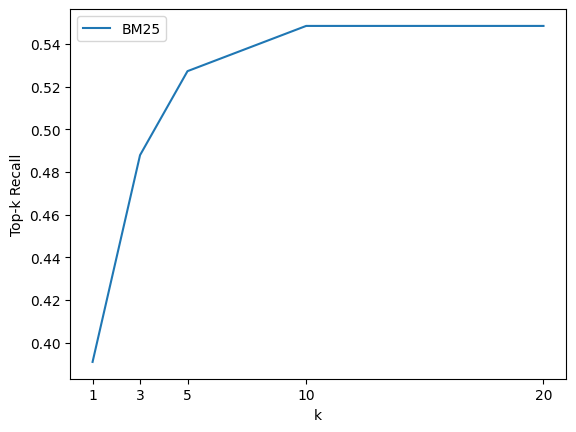

In [78]:

def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()
    
plot_retriever_eval([bm25_topk_df], ["BM25"])

From the plot, we can see that there's an inflection point at k=5 then the recall score gets saturated after that.

#### Dense Passage Retrieval

Can we get good scores with less k? The advantage of doing so is that we can pass fewer documents and reduce the overall latency of QA pipeline. A well-known limitation of sparse retrievers is that they fail to capture relevant documents when the words in user query doesn't match the exact terms in review. One promising alternative is to use dense representations fo document and query. The current state of the art architecture known as *Dense Passage Retrieval(DPR)*. The main idea behind DPr is to use a BERT encoder for question and document. The encoders map the input into a d-dimensional vector representation of the `[CLS]` token.

*DPR bi-encoder architecture*

![alt](../notes/images/7-question-answering/qa-dpr-retriever.png)

In Haystack, we can initialize a retriever for DPR in a similar way to what we did for BM25.
In addition to specifying the document store, we've to pass encoder for question and passage.
We train the encoders by passing question, relevant and irrelevant answers. The goal is to learn that relevant question-passage pairs have a higher similarity. For our case, we'll use the encoders that is fined tuned on the NQ corpus this way:

In [4]:
from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(
    document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False,
)

/Users/jayaprakashsivagami/miniconda3/envs/nlp-qa/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


`embed_title` to False to avoid creating embeddings for `item_id` as we filter per product during our retrieval. Once we've intialized the retriever the next step is to iterate over all the documents in our ElasticSearch index and apply the encoders to update the embedding representation.

In [17]:
document_store.update_embeddings(
    retriever=dpr_retriever,
)

Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Updating embeddings: 10000 Docs [25:02,  6.65 Docs/s]           


In [82]:
dpr_topk = evaluate_retriever(
    retriever=dpr_retriever
)
dpr_topk_df = pd.DataFrame.from_dict(dpr_topk, orient="index")
dpr_topk_df

/Users/jayaprakashsivagami/Documents/Tech/ML/nlp-with-hugging-face/haystack/haystack/schema.py:1465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/Users/jayaprakashsivagami/Documents/Tech/ML/nlp-with-hugging-face/haystack/haystack/schema.py:1465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/Users/jayaprakashsivagami/Documents/Tech/ML/nlp-wit

,recall
1,0.327273
3,0.484848
5,0.524242
10,0.551515
20,0.551515


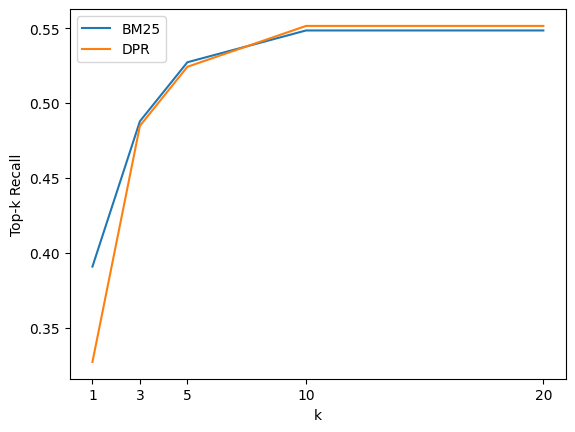

In [83]:
plot_retriever_eval([bm25_topk_df, dpr_topk_df], ["BM25", "DPR"])

Here DPR doesn't provide a boost in recall over BM25 and saturates around k=3.

> **Note:** Similairty search of embeddings can be sped up by using Facebook's FAISS library. To fine tune DPR retriever refer [tutorial from haystack](https://oreil.ly/eXyro)

Next let's move on to Evaluating the reader.

### Evaluating the Reader

In extractive QA, there are two main metrics that are used for evaluating the reader:

*Exact Match (EM)*

A binary metric that gives EM=1 if the characters in the predicted and ground truth match exactly and EM=0 otherwise. If no answer is expected, the model gets EM=0 if it predicts any text all.

*F1-score*

Harmonic mean of precision and recall.

Let's see how these metrics wit some helper functions from FARM over a simple example.

In [61]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label,pred)}")

EM: 0
F1: 0.8


In [62]:
pred = "6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label,pred)}")

EM: 1
F1: 1.0


In [63]:
pred = "about 6000 dollars"
label = "about 6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label,pred)}")

EM: 0
F1: 0.6666666666666666


Under the hood, these functions first normalize the prediction and label by removing puntuation, fixing whitespace, and converting to lowercase. The normalized strings are then converted to bag-of-words, then metric is calculated at the token level.

In this example,

* adding an additional word to prediction gives EM as 0
* f1 gives an score 0.6 for *about 6000 dollars* which is incorrect answer
* Relying on just one of these will be misleading, and tracking both metrics is a good strategy to balance the trade-off between (EM) and overestimating(f1-score) morel performance.

*How the score is calculated for multiple question answer pair?*

* First the score is calculated for multiple answers paired with a question
* Then the answer with highest score is selected over all possible answers
* Finally average of the indiviual score is calculated to get the final score.

The evaluation of reader is done by creating a pipeine that consists of a single node, reader in this case. Then `eval()` to evaluate the reader with labels index.

In [64]:
labels_agg[0].labels[0].__dict__

{'id': 'e3af3a43-f6d9-4f4d-8b3e-226e02b44210',
 'created_at': '2023-09-19 06:35:34',
 'updated_at': '2023-09-19 06:35:34',
 'query': 'What is the tonal balance of these headphones?',
 'answer': <Answer {'answer': 'I have been a headphone fanatic for thirty years', 'type': 'extractive', 'score': None, 'context': None, 'offsets_in_document': None, 'offsets_in_context': None, 'document_ids': None, 'meta': {}}>,
 'document': <Document: {'content': "I have been a headphone fanatic for thirty years and have owned and used a variety of headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580.  The Sony MDRV6 excells as the best value of any headphone that I've ever owned.  They are especially good at producing natural-sounding deep bass, and the overall octave-to-octave balance is excellent.  The sound quality is all in all comparable to other headphones that cost considerably more.The MDRV6 is especially well-suited for travel due to the collapsible design, and for noi

In [65]:
from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(
        component=reader,
        name="Reader",
        inputs=["Query"],
    )
    eval_result = p.eval(
        labels=labels_agg,
        documents=[[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

In [70]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

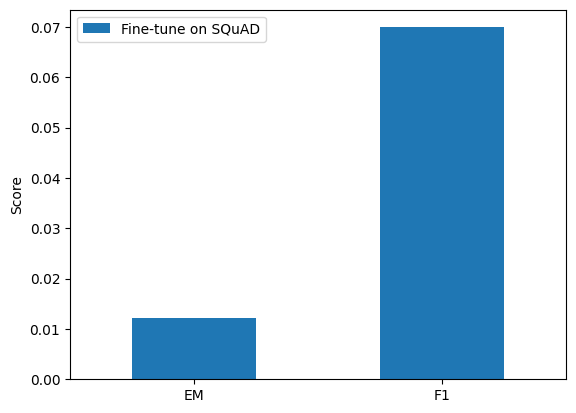

In [71]:
plot_reader_eval(reader_eval=reader_eval)

Ok, the fine-tuned model performs significantly worse on SubjQA than on SQuAD 2.9, where MiniLM achieves EM and f1 scores of 76.1 and 76.5. The reasons might be:
* Customer revies are quite different from the wikipedia articles the SQuAD 2.0 dataset is generated from and the language is informal. 
* Wikipedia articles are factual information and reviews are inherently subjective.

Next let's look at fine-tuning models on a datset to get better results with domain adaptaion

## Domain Adaptaion

The failure to generalize is observed on other extractive QA datasets and is understood as evidence that transformers models are adept at overfitting to SQuAD. The `FARMReader` has a `train()` method to fine-tune on a dataset. This method expects data to be in SQuAD JSON format where all the question-anwer pairs are grouped together for each item like the image below.

*SQuAD json format*

![alt](../notes/images/7-question-answering/squad-json-format.png)

This is quite a complex data format, let's create it. First we'll implement a function that can creae the `paragraphs` array associated for each product ID. Each element in the arrayu is review and qas pair.

In [87]:
# We'll use the dataframe
df

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective
0,electronics,neutral,sound,present,bass,8fbf26792c438aa83178c2d507af5d77,1,0.5,False,d040f2713caa2aff0ce95affb40e12c2,455575557886d6dfeea5aa19577e5de4,B00001P4ZH,I have had many sub-$100 headphones from $5 Pa...,How is the bass?,[],[],[],[],[]
1,electronics,clear,view,easy,time,c68a6cc477b67ae54dbe15fc19b1e2fc,3,0.0,False,acc40990720aba8c38ecc7cda49b4d94,47110eb7720cffd03bb78f609999243d,B00004SABB,the view is so good and clear and so easy to f...,How is the time?,[],[],[],[],[]
2,electronics,clear,high,solid,bass,6521176a0cf9742c793c6c2a348eb3a6,5,0.5,False,12896447561b4f7947c99f5cccdedc7b,0645f5f9fabb5276fea9c572fb1d378d,B000062VUO,I first fell in love with Klipsch in the 80s w...,What is the bass provide?,[Bass booms],[252],[5],[0.5],[False]
3,electronics,perfect,color,amazing,color,a93b18abb223549010a8e676cfb2ffb0,1,0.0,False,9f8869ddd92ade59a4db128972492c67,063fe5ccf8860dc591bacec10c8735d5,B00007E7JU,"I love my 50mm. At f/1.8, it's close to imposs...",What does it tell us about the color?,[],[],[],[],[]
4,electronics,impressive,picture,great,image,231254b7eb9ef7da363ed86cb9eea0df,5,0.6,True,26128195da35fe33ca351524017b6d56,5f9ca4c7ca86909bd58bb2713eb3b091,B00007GQLU,Simply the best lens I have ever used. Make s...,How good is the image of this camera?,[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,electronics,right,size,more reasonable,price,bd9a52715ed9ceabbc2115176d70e6d4,1,0.2,False,d4f9c6f9af5e705eb1bf6fa1b019624a,62326ee218c2e24b73f9b23f55208b72,B00DVFLJDS,This smartphone meets my needs.. The size is j...,How much is the price to pay?,[],[],[],[],[]
251,electronics,good,resolution,amazing,resolution,f582f22fe9c904bd60e3b8b70eef1e30,5,0.0,False,d2ebd99eafe1b7ccc884548525f83f94,07285ed920b2056bb427614f9e6c6116,B00F3SOHNU,[Edit 10/27/2013]After I began to edit the rev...,How was my camera's resolution?,[],[],[],[],[]
252,electronics,good,brightness,brilliant,color,bf4b46c7643ef312f869d92941b802f8,1,0.0,False,7c971b6ee956bef3b7faa4dd88575f0c,12012d3d628622059784d550e5025b90,B00FEE7B1I,I've been running the Dell Venue Pro 8 daily f...,What color is brighter?,[form factor really],[101],[1],[0.2],[False]
253,electronics,tight,case,great,protection,ed6533390fe2fe0d546b69dea570c34b,3,0.0,False,ebaaec25661c0b21f3e5600a1ed7e30b,ee5906ed3306b7c6d219a40adae2c7c2,B00H3OYSHW,I ordered my new NewTrend Airbender Pro NT610K...,How does the selector protection me?,[it)Protective Capability~5],[3039],[1],[0.0],[False]


In [93]:
# Each review is associated with multiple questions
df[df['review_id'] == "6b05cce6f0560eb8b3b09f3caee5d106"]

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective
238,electronics,quick,setup,simple,set,2c32c671de4be5bbc6feab910a76ae7f,1,0.357143,False,6b05cce6f0560eb8b3b09f3caee5d106,a3fbfadc0d70c5e40ea140ffd7de8f58,B00DR0PDNE,I hooked this thing up today and have taken it...,What is the set of simple things you need?,[],[],[],[],[]
239,electronics,quick,setup,fast,setup,7e0c413897fad8b90fe917017f522b8b,1,0.000000,False,6b05cce6f0560eb8b3b09f3caee5d106,b5b21ab6463b1189c64c01592a882b54,B00DR0PDNE,I hooked this thing up today and have taken it...,Where can I send to setup my device?,[],[],[],[],[]


In [ ]:
question_df = df.query(f"id == '455575557886d6dfeea5aa19577e5de4'").to_dict(orient="list")
question_df

In [118]:
def create_paragraphs(df):
    # To store paragraph, qas pairs
    paragraphs = []
    # Colllect all context(one is associated with multiple questions) with review_ids(unique)
    id2context = dict(zip(df["review_id"], df["context"]))
    # Loop through each review_id to get all questions
    for review_id, review in id2context.items():
        # To store all questions for a single context
        qas = []
        # Collect all questions
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df['question']))
        # Build the qas array
        for qid, question in id2question.items():
            # Filter for question ID
            question_df =df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idx = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()

            if len(ans_start_idx):
                answers = [
                    {
                        "text": text,
                        "answer_start": answer_start,
                    }
                    for text, answer_start in zip(ans_text, ans_start_idx)
                ]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            qas.append(
                {
                    "question": question,
                    "id": qid,
                    "is_impossible": is_impossible,
                    "answers": answers
                }
            )
        # add qas - question-answer pairs to paragraphs
        paragraphs.append(
            {
                "qas": qas,
                "context": review
            }
        )
    return paragraphs


In [119]:
# Testing for a single product, to verify the SQuAD format
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

This function gives qas, review in SQuAD format for a single product df.

In [120]:

import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # Create `paragraphs` for each product ID
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)
            
convert_to_squad(dfs)

Now that we've the splits in the right format, let's fine-tune our reader by specifying the locations of the train and dev splits, along with saving the fine-tuned model.

In [72]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"
reader.train(
    data_dir=".",
    use_gpu=False,
    n_epochs=1,
    batch_size=16,
    train_filename=train_filename,
    dev_filename=dev_filename,
)

Preprocessing dataset:  33%|███▎      | 1/3 [00:02<00:05,  2.81s/ Dicts]Answer using start/end indices is '  Operation of the menus and contro' while gold label text is 'Operation of the menus and controls'.
Example will not be converted for training/evaluation.
Answer using start/end indices is '  This camera performs like the pros.  Fast accurate and easy to operat' while gold label text is 'This camera performs like the pros.  Fast accurate and easy to operated'.
Example will not be converted for training/evaluation.
Preprocessing dataset:  67%|██████▋   | 2/3 [00:04<00:02,  2.20s/ Dicts]Answer 'enjoy my music.  When I used my old one ear headset for music, the connection was not that good even if I put the phone in my pants pocket.  I used it on iPhone 4S and iPad 3 for music, phone calls, and audible app.  All Bluetooth controls work fine. ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
Answer 'is good.  First unit defective.  Direc

Let's evaluate the fine tuned model.

In [74]:
reader.save(
    directory="../models/qa-reader-fine-tuned-on-squad-and-subjqa/"
)

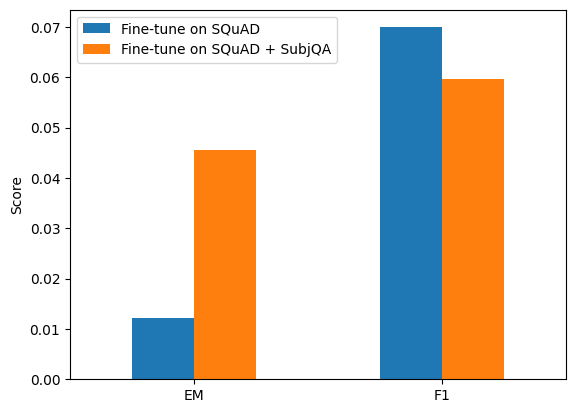

In [73]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(
    reader=reader
)
plot_reader_eval(
    reader_eval=reader_eval
)

Nice! Fine-tuning on has increased the EM score and F1 is almost equal to old score. One reaason for not fine tuning with SujQA is it has only 1,295 examples and might've led to overfitting. Let's try out fine-tuning on SubjQA alone.

In [76]:
# Using same reader for fair evaluation
from haystack.nodes import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 348, 128
minilm_reader = FARMReader(
    model_name_or_path=model_ckpt,
    progress_bar=True,
    max_seq_len=max_seq_length,
    doc_stride=doc_stride,
    return_no_answer=True
)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [77]:
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing dataset:  33%|███▎      | 1/3 [00:02<00:05,  2.71s/ Dicts]Answer using start/end indices is '  Operation of the menus and contro' while gold label text is 'Operation of the menus and controls'.
Example will not be converted for training/evaluation.
Answer using start/end indices is '  This camera performs like the pros.  Fast accurate and easy to operat' while gold label text is 'This camera performs like the pros.  Fast accurate and easy to operated'.
Example will not be converted for training/evaluation.
Preprocessing dataset:  67%|██████▋   | 2/3 [00:05<00:02,  2.74s/ Dicts]Answer 'enjoy my music.  When I used my old one ear headset for music, the connection was not that good even if I put the phone in my pants pocket.  I used it on iPhone 4S and iPad 3 for music, phone calls, and audible app.  All Bluetooth controls work fine. ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
Answer 'is good.  First unit defective.  Direc

In [80]:
minilm_reader.save(
    "../models/qa-reader-fine-tuned-on-subjqa/"
)

In [78]:
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  1.27 Batches/s]


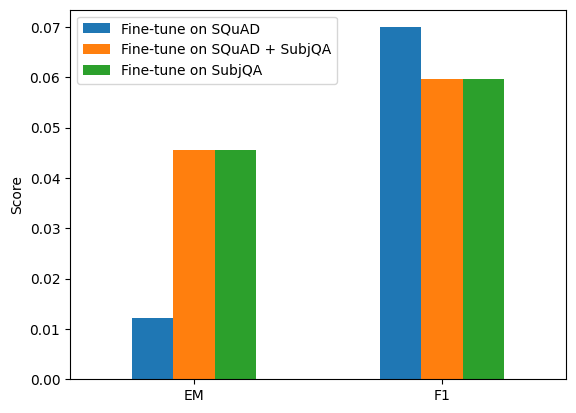

In [79]:
plot_reader_eval(reader_eval)

Directly fine-tuning on SubjQA gives similar results, but these might not occur everytime.

> **Warning:** When dealing with small datasets, it is best practice to use cross-validation when evaluating transformers as they can be prone to overfitting. An example for cross-validation with SQuAD-formatted datasets in the [FARM repository](https://github.com/deepset-ai/FARM/blob/master/examples/question_answering_crossvalidation.py)

## Evaluating the whole QA pipeline

Now that we've seen how to evaluate the reader and retriever components individually, let's tie them together to measutre the overall performance of our pipeline. To do so we've augment our retriever pipeline with nodes for the reader and its evaluation. We've got good recall at k=10, let's fix this value and asses the impact this has on the reader's performance(since it will recieve multiple contexts per query compared to the SQuAD-style evaluation).

In [81]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(
    retriever=bm25_retriever,
    reader=reader,
)

# Evaluate
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(
    simulated_top_k_reader=1,
)
reader_eval["QA Pipeline (top-1)"] ={
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]
}

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.42 Batches/s]


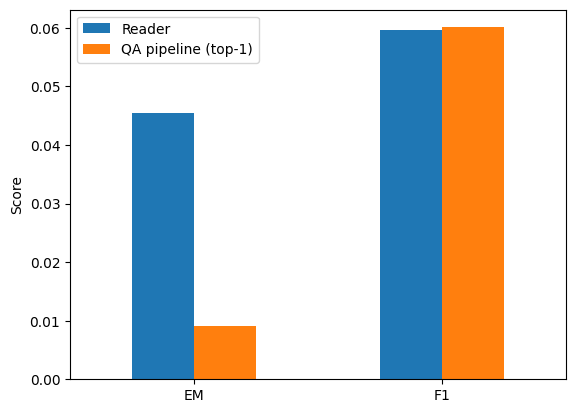

In [83]:
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

From this plot we can see the effext that the retriever has on the overall performance.

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.98 Batches/s]


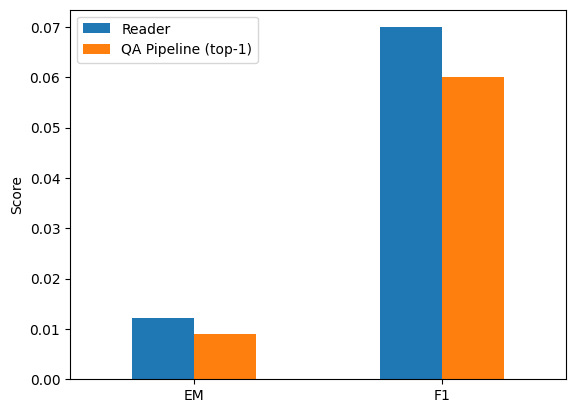

In [84]:
# Or get QA pipeline and Reader metrics in one shot:
# Reader evaluation is run a second time using simulated perfect retriever results
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
    add_isolated_node_eval=True
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader run in isolation with simulated perfect retriever
isolated_metrics = eval_result.calculate_metrics(simulated_top_k_reader=1, eval_mode="isolated")

pipeline_reader_eval = {}
pipeline_reader_eval["Reader"] = {
    k:v for k,v in isolated_metrics["Reader"].items()
    if k in ["exact_match", "f1"]}
pipeline_reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

plot_reader_eval(pipeline_reader_eval)

Until now we've only extracted answer spans from the context, but in general it could be that bits and pieces of the answer are scattered throughout the document and we would like our model to synthesize these fragments into a single coherent answer. Let's have a look at how we can use generative QA to succeed at this task.

## Going Beyond Extractive QA

One interesting alternative to extracting spans of answers of text in a document is to generate them with a pretrained language model. This approach is called *abstractive or generative QA* and has the potential to produce better phrased answers than answers synthesized from mutliple passages. We'll breifly toucj on the current state of art: *retrieval-augmented generation* (RAG).

RAG extends the retriever-reader architecture by replacing the reader with genereator and DPR as the retriever. The generator is a pretrained sequence-to-sequence transformer like T5 or BART that reciever latent vectors of documents from DPR then iterativley generates an anser based on the query and these documents.

There are two types of generator or RAG models:

*RAG-Sequence*:
Uses the same retrieved document to generate an complete answer. In particular, the top k documents are fed to the generator, which produces and output for each document, and the result is marginalized to obtain the best answer.

*RAG-token*:
Uses different documents to generate each token in the answer. This allows the generator to synthesize evidence from multiple documents.

We'll use RAG-Token models as they have better performance than RAG-Sequence ones. We'll instatiate the generator from hasytack with a different set of params.

In [13]:
from haystack.nodes import PromptNode

generator = PromptNode()

In [14]:
from haystack.pipelines import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

In [23]:
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(query=query, 
                     params={"Retriever": {"top_k":5, 
                                  "filters":{"item_id": ["B0074BW614"]}},})  
    print(f"Question: {preds['query']} \n")
    for idx in range(top_k_generator):
        print(f"Answer {idx+1}: {preds}")
     

In [24]:
generate_answers("What is the main drawback?")

Question: What is the main drawback? 

Answer 1: {'results': [], 'invocation_context': {'query': 'What is the main drawback?', 'documents': [<Document: {'content': 'Let me begin this by saying that I used to be an "early adopter".  I had to have it when it first came out.  I\'ve stopped doing that, but in this case I wish I had bought the first Fire.  From using a friend\'s I was excited when they finally announced the second gen devices.  The original was simple to use and did most things I wanted it to.  This one is incredibly hard to figure out, even with years of techy experience and is more limited in its use.PROS -Feels solid and well built.Anti-glare screen is nice, and the screen is vibrant.  It\'s not Retina, but then it didn\'t cost like one so I\'m OK with that.Some have reported it being slow and unresponsive, but I haven\'t had much of a problem except when in apps I know have problems from them doing the same to my phone.  Videos streamed from Amazon look really good.Book

# Conclusion

In this notbeook, we've explored differente retirevers, readers, generators and evaluated them with common metrics for such systems. The techniques we used on closed-domain QA(on single domain of electronice products) can be generalized to the open domain case. 

For more checkout cloudera's [QA series](https://oreil.ly/Fd6lc)

Deploying QA systems in the wils can be a tricky buisness to get right, a significant part of the values comes from providing users with useful search capabalities, followed by a extractive component.

## Models

*Generation* T5, RAG, GPT4
*Extraction* Zero shot NER, domain adaptaion
*Search* TF-IDF, BM25, DPR

Other intersting idead include,
* multiModal QA over multiple modalities like text, tables and images
* QA over knowledge graph, where nodes correspond toi real-word entities and their relations are defined by the edges. 
* Automatic question generation as a way to do some supervised training using unlabeled data or data augmentation.